# 필요한 라이브러리 임포트

In [ ]:
import re
import string
import logging
import hashlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from urllib.parse import urlparse
import tldextract
import whoisdomain

import ipaddress
import dns.resolver

url_data = pd.read_csv('../datasets/merged.csv')
url_data.head()

# 데이터 전처리

### 1) URL 데이터에서 www. 을 제거

In [ ]:
url_data['url'] = url_data['url'].replace('www.', '', regex=True)
url_data.head()

### 2) URL 데이터에서 Type 열을 레이블 인코딩
학습과정이 아닌 앱에서 불러온 URL의 특성을 추출하는 과정에서는 생략해야함

benign => 0 (정상) <br/>
defacement, phishing, malware => 1 (비정상)

=> 정상을 제외한 defacement, phishing, malware를 전부 1로 처리

In [ ]:
url_data['url_type'] = url_data['type'].replace({
    'benign':0,
    'defacement':1,
    'phishing':1,
    'malware':1
});

In [ ]:
url_data.head()

### 3) 접두어 http://, https:// 를 제외한 나머지 URL 주소의 길이를 구해 새로운 열(url_len)에 추가

In [ ]:
def get_url_length(url):
  # 일반적인 URL의 접두어를 제외한 주소의 길이를 구함
  headers = ['http://', 'https://']
  for header in headers:
    if url.startswith(header):
      url = url[len(header):]

  # 주소의 길이 반환
  return len(url)

In [ ]:
url_data['url_length'] = url_data['url'].apply(lambda x: get_url_length(str(x)))

In [ ]:
url_data.head()

### 4) 주어진 URL에서 서브 도메인, 도메인 이름, 최상위 도메인(TLD)을 추출하여 새로운 열(pri_domain)에 저장 <br/><br/>
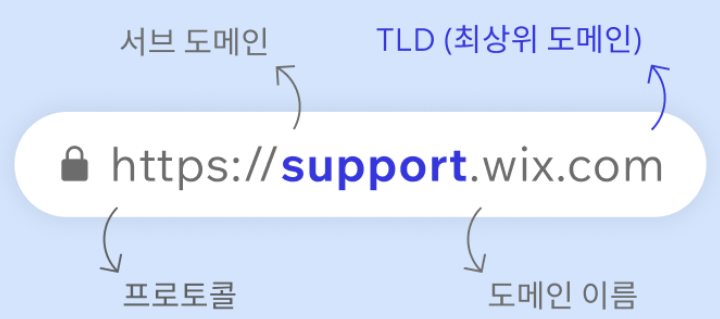


In [ ]:
from tld import get_tld

# 주어진 URL에서 기본 도메인을 추출하는 함수
def extract_pri_domain(url):
  try:
    # get_tld 함수를 이용하여 주어진 URL에서 최상위 도메인을 추출
    res = get_tld(url, as_object = True, fail_silently=False, fix_protocol=True)
    # 주어진 URL에서 기본 도메인을 추출
    pri_domain = res.parsed_url.netloc
  except:
    # 오류 발생 시 기본 도메인을 None으로 설정
    pri_domain = None
  return pri_domain


In [ ]:
url_data['pri_domain'] = url_data['url'].apply(lambda x: extract_pri_domain(x))

In [ ]:
url_data.head()

### 5) 주어진 URL이 URL 단축 서비스를 사용하는지 확인한 후 새로운 열(shorten_service)에 추가

<br/>

사용하고 있는 경우 => 1

사용하지 않는 경우 => 0

In [ ]:
def classify_shorten_service(url):
    # 도메인 부분을 추출하는 패턴(http:// or https://로 시작하고 www. 이후에 오는 패턴)
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)

    if match:
        domain = match.group(1)
        # URL 단축 서비스의 도메인 목록
        shorten_services_list = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping',
                                      'post', 'Just', 'bkite', 'snipr', 'fic',
                                      'loopt', 'doiop', 'short', 'kl', 'wp',
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd',
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur',
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is',
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl',
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro',
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url',
                                      'tweez', 'v', 'tr', 'link', 'zip']

        # 추출된 도메인이 URL 단축 서비스의 도메인 목록에 있는지 확인
        if domain.lower() in shorten_services_list:
            return 1    # 있으면 1 리턴
    return 0  # 없으면 0 리턴

In [ ]:
url_data['shorten_service'] = url_data['url'].apply(lambda x: classify_shorten_service(x))

In [ ]:
url_data.head()

## 6) 주어진 URL이 일반적인 URL의 형식을 갖추고 있는지 확인한 후 새로운 열(abnormal_url)에 저장 <br/>

정상 => 1 <br/>

비정상 => 0

In [ ]:
def abnormal_url(url):
  parsed_url = urlparse(url)  # 입력된 URL의 구문 분석
  netloc = parsed_url.netloc
  if netloc:  # netloc이 비어 있지 않다면
    netloc = str(netloc)
    match = re.search(netloc, url)
    if match:
      return 1
  return 0

In [ ]:
url_data['abnormal_url'] = url_data['url'].apply(lambda x: abnormal_url(x))

In [ ]:
url_data.head()

### 7) 주어진 URL이 https를 사용하고 있는지 확인 후 새로운 열(https)에 저장
<br/>

사용 중 => 1 <br/>

사용 X => 0

In [ ]:
def https(url):
  return int(urlparse(url).scheme == 'https')

In [ ]:
url_data['https'] = url_data['url'].apply(lambda x: https(x))

In [ ]:
url_data.head()

### 8) 주어진 URL에 IP 주소가 포함되어 있는지 여부를 확인한 후 여부를 새로운 열(have_ip)에 저장

<br/>

IP주소가 IPv4 또는 IPv6 주소인 경우 ==> 1
<br/>

그렇지 않은 경우 ==> 0


In [ ]:
def have_ip(url):
  try:
    parsed_url = urlparse(url)
    if parsed_url.hostname:
      ip = ipaddress.ip_address(parsed_url.hostname)
      return int(isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address)))
  except ValueError:
    pass

  return 0

In [ ]:
url_data['have_ip'] = url_data['url'].apply(lambda x: have_ip(x))

In [ ]:
url_data.head()

### 9) 주어진 URL의 최상위 도메인(root domain)을 추출하여 새로운 열에 저장

In [ ]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

In [ ]:
url_data['root_domain'] = url_data['pri_domain'].apply(lambda x: extract_root_domain(str(x)))

In [ ]:
url_data.head()

### 10) 주어진 URL에 사용된 특수문자의 개수를 구한 후 새로운 열(count_characters)에 저장

In [ ]:
def count_special_characters(url):
    special_characters = set("!@#$%^&*()_+{}[]|\:;\"'<>,.?/")
    count = 0
    for char in url:
        if char in special_characters:
            count += 1
    return int(count)

url_data['count_characters'] = url_data['url'].apply(lambda x: count_special_characters(str(x)))

In [ ]:
url_data.head()

### 11) 해당 URL의 root_domain의 길이를 새로운 열(root_domain_length)에 저장

In [ ]:
def root_domain_len(root_domain):
  return int(len(root_domain))

In [ ]:
url_data['root_domain_length'] = url_data['root_domain'].apply(lambda x: root_domain_len(x))

In [ ]:
url_data.head()

### 12) URL에서 이메일 주소 포함 여부, 특정 파일 확장자 포함 여부를 구한 후 각각 새로운 열(exist_email, exist_file_extension) 에 추가

<br/>

각각 포함되어 있으면 ==> 1
<br/>

포함되어 있지 않으면 ==> 0

In [ ]:
# URL에서 이메일 주소 추출하는 함수
def extract_email(url):
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    return 1 if re.findall(email_pattern, url) else 0

# URL에서 특정 파일 확장자가 존재하는지 확인하는 함수
def has_file_extension(url, extensions):
    for ext in extensions:
        ext_pattern = r'\b\.' + ext + r'\b'
        if re.search(ext_pattern, url, re.IGNORECASE):
            return 1
    return 0

In [ ]:
extensions = ['exe', 'pdf', 'docx', 'xlsx', 'zip', 'mp3', 'mp4', 'jpg', 'png', 'gif', 'txt', 'csv', 'xml', 'json', 'html']

url_data['exist_email'] = url_data['url'].apply(lambda x: extract_email(x))
url_data['exist_file_extension'] = url_data['url'].apply(lambda x: has_file_extension(x,extensions))

In [ ]:
url_data.head()

### 13) 각 url의 도메인 등록 기간을 추출하여 새로운 열(url_period)에 저장

In [ ]:
def get_url_period(url):
    try:
        domain = whoisdomain.query(url)

        if type(domain.expiration_date) is list:
            expiration_date = domain.expiration_date[0]
        else:
            expiration_date = domain.expiration_date

        if type(domain.last_updated) is list:
            updated_date = domain.last_updated[0]
        else:
            updated_date = domain.last_updated
        
        total_date = (expiration_date - updated_date).days
        
        return total_date
    except Exception as e:      # DNS가 조회되지 않을시
        return 0               # 0 리턴

In [ ]:
url_data['url_period'] = url_data['pri_domain'].apply(lambda x: get_url_period(x))

### 14) 각 url의 TTL을 추출하여 새로운 열(ttl)에 저장

In [ ]:
def get_domain_ttl(domain):
    try:
        answer = dns.resolver.resolve(domain, 'A')
        print(answer.rrset.ttl)
        return answer.rrset.ttl
    except Exception as e:
        return 0

In [ ]:
url_data['ttl'] = url_data['pri_domain'].apply(lambda x: get_domain_ttl(x))

### 15) 학습에 필요하지 않은 열 제거

In [ ]:
# 제거하려는 열의 리스트
columns_to_remove = ['url', 'type', 'pri_domain', 'root_domain']

In [ ]:
# 특정 열 제거
url_data = url_data.drop(columns_to_remove, axis=1)

# 전처리된 데이터 저장

In [ ]:
url_data.to_csv('../datasets/Final_Data.csv', index = False)